Risk-neutral expectation pricing in continuous time: 

\begin{align}\frac{C_{t}}{B_{t}} = \mathbb{E_{Q}}\left[\frac{C_{t}}{B_{t}}|F_{t}\right]\end{align}

In [1]:
import math
import numpy as np
import pandas as pd 
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt 
from pandas_datareader import data as pdr

In [6]:
import time

def tic():
    global start_time
    start_time = time.time()

def toc():
    if 'start_time' in globals():
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time} seconds")
    else:
        print("Tic function has not been called yet.")

## Valuation by simulation 

value of an option = risk-neutral expectation of discounted payoff

For a single simulation: $C_{0,i} = e^{-\int_{0}^{T} r_{s} ds}C_{T,i} = e^{-rT}C_{T,i}$

Average across $M$ simulation: $\hat{C_{0}} = \frac{1}{M} \sum_{i=1}^{M} C_{0,i}$

Standard error: $SE(\hat{C_{0}}) = \frac{\sigma(C_{0,i})}{\sqrt{M}}$, where $\sigma(C_{0,i}) = \sqrt{\frac{1}{M-1}\sum_{i=1}^{M}(C_{0,i}-\hat{C_{0}})^{2}}$

## European call option in a Black-Scholes World

Geometric Brownian Motion: $dS_{t} = rS_{t}dt + \sigma S_{t}dW_{t}$

Let $X \sim (x_{t} = \ln{S_{t}}, \sigma^{2})$, since $x_{t} = \ln{S_{t}}$ is normally distributed. 

### Discretization of the stochastic differential equation (SDE)

$dx_{t} = vdt + \sigma dz_{t}, \: v = r-\frac{1}{2}\sigma^{2}$

$\implies \Delta x = v\Delta t + \sigma \Delta z$

$\therefore x_{t+\Delta t} = x_{t} + v\Delta t + \sigma(z_{t+\Delta t} - z_{t})$

### Application to stock prices

$S_{t+\Delta t} = S_{t} e^{v\Delta t + \sigma(z_{t+\Delta t} - z_{t})}$, where $(z_{t+\Delta t} - z{t}) \sim N(0,\Delta t) \sim \sqrt{\Delta t}N(0,1)\sim\sqrt{\Delta t}\epsilon_{i}$

In [13]:
# Initializing derivative parameters 
S = 101.15 # stock price
K = 98.01 # strike price 
vol = 0.0991 # volatility (%)
r = 0.01 # risk-free rate (%)
N = 10 # number of time steps 
M = 100 # number of simulations

market_value = 3.86 # market price of option
T = ((datetime.date(2025,1,7) - datetime.date.today()).days+1)/365 # time in years 
print(T)

0.25753424657534246


### Slow solution using steps

In [14]:
tic()
# Precomputing constants 
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Standard Error parameters
sum_CT = 0
sum_CT2 = 0

# MC method 
for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + volsdt*np.random.normal()
        
    ST = np.exp(lnSt)
    CT = max(0, ST - K)
    sum_CT += CT
    sum_CT2 += CT**2
    
# Computing expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt((sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1))
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
time.sleep(2)
toc()

Call value is $3.82 with SE +/- 0.42
Elapsed time: 2.0106072425842285 seconds


### Fast solution using vectorization 

In [15]:
tic()
# Precomputing constants 
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# MC method 
Z = np.random.normal(size=(N,M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate((np.full(shape=(1,M), fill_value=lnS), lnSt))

# Compute expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt(np.sum((CT[-1] - C0)**2) / (M-1))
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
time.sleep(2)
toc()

Call value is $4.06 with SE +/- 0.4
Elapsed time: 2.003498077392578 seconds


## Visualization of convergence

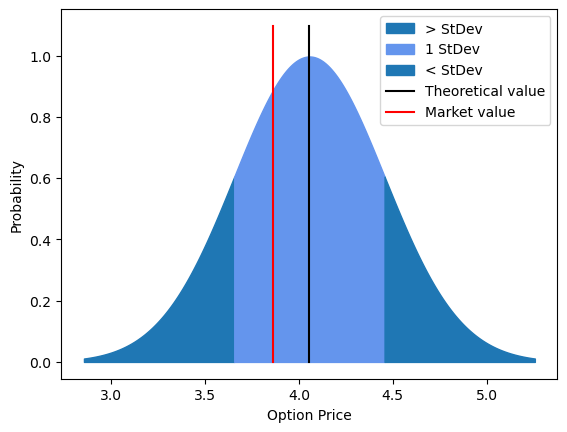

In [16]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue', label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue', label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue', label='< StDev')

plt.plot([C0, C0], [0, max(s2)*1.1], 'k', label='Theoretical value')
plt.plot([market_value, market_value], [0, max(s2)*1.1], 'r', label='Market value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()